In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Data Preparation
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(
    root="/Users/dong-ju/Documents/My_code/file_images/images/", transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [3]:
# Define the CNN Architecture with added max-pooling layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 62 * 62, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Initialize model, loss, and optimizer
model = SimpleCNN()

In [5]:
# Use cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
# Initialize loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training Loop
for epoch in range(10):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"[Epoch {epoch + 1}] loss: {loss.item()}")
print("Finished Training")

[Epoch 1] loss: 0.7221755385398865
[Epoch 2] loss: 1.192092735635697e-08
[Epoch 3] loss: 0.0
[Epoch 4] loss: 0.0
[Epoch 5] loss: 0.0
[Epoch 6] loss: 0.0
[Epoch 7] loss: 0.0
[Epoch 8] loss: 0.0
[Epoch 9] loss: 0.0
[Epoch 10] loss: 0.0
Finished Training


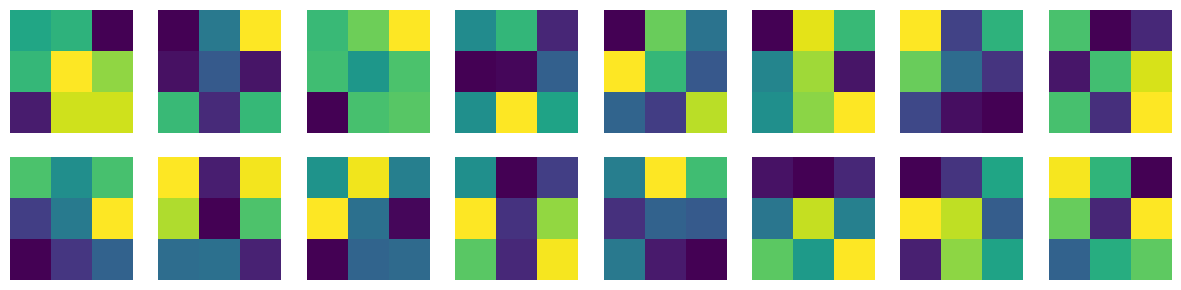

In [19]:
# Visualize model - 1
filters = model.conv1.weight.detach().cpu().numpy()
plt.figure(figsize=(15, 15))
for i in range(filters.shape[0]):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[i, 0, :, :])
    plt.axis("off")
plt.show()

Hook triggered! Shape of feature_maps: (20, 16, 254, 254)
Shape of feature_maps after forward pass: (20, 16, 254, 254)


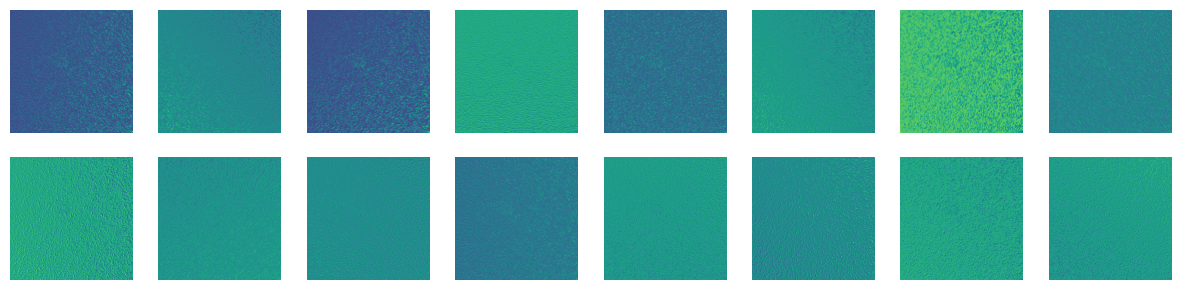

In [12]:
# Visualize model - 2
def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output.detach().cpu().numpy()
    print("Hook triggered! Shape of feature_maps:", feature_maps.shape)


hook = model.conv1.register_forward_hook(forward_hook)

with torch.no_grad():
    model(inputs)

if "feature_maps" in globals():
    plt.figure(figsize=(15, 15))
    num_feature_maps = feature_maps.shape[1]

    # Determine the number of channels in the feature maps
    num_channels = feature_maps.shape[2]

    for i in range(num_feature_maps):
        plt.subplot(8, 8, i + 1)
        if num_channels == 3:
            # visualize it in RGB
            plt.imshow(feature_maps[0, i, :, :, :])
        else:
            # visualize it with a colormap
            plt.imshow(feature_maps[0, i, :, :], cmap="viridis")
        plt.axis("off")
    plt.show()

hook.remove()

In [13]:
# TEST AREA
image_path = (
    "/Users/dong-ju/Documents/My_code/file_images/images/malicious/sample_files8.png"
)
input_image = Image.open(image_path)
input_image = input_image.convert("RGB")

preprocess = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_batch = input_batch.to(device)

# Run a forward pass
with torch.no_grad():
    output = model(input_batch)

# Get the predicted label (argmax of the softmax output)
_, predicted_idx = torch.max(output, 1)
class_labels = ["not malicious", "malicious"]

print(f"Predicted class: {class_labels[predicted_idx.item()]}")

Predicted class: not malicious


In [14]:
# Existing code to get the model output
with torch.no_grad():
    output = model(input_batch)

# Adjust the softmax temperature
temperature = 0.5
scaled_output = output / temperature

# Get the probabilities and confidence
probabilities = F.softmax(scaled_output, dim=1)
_, predicted_idx = torch.max(probabilities, 1)
confidence = probabilities[0][predicted_idx].item()

print(f"Predicted class: {class_labels[predicted_idx.item()]}")
print(f"Confidence: {confidence * 100:.2f}%")

Predicted class: not malicious
Confidence: 100.00%


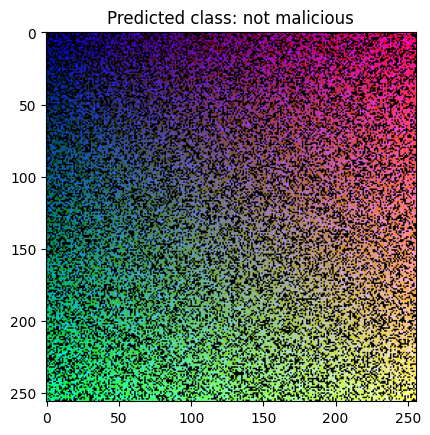

In [15]:
plt.imshow(input_image)
plt.title(f"Predicted class: {class_labels[predicted_idx.item()]}")
plt.show()